## Hash Algorithm and Image Generator

In [1]:
import hashlib
import os
import pathlib
import random
import re
from collections.abc import Iterable, Iterator
from functools import partial, cache
from itertools import chain, tee
from math import cos, radians, sin
from pathlib import Path
from random import choice, randint, shuffle
from typing import (
    Any,
    Callable,
    ClassVar,
    NamedTuple,
    NoReturn,
    Optional,
    Sequence,
    Type,
    TypeVar,
    Union,
)

from attrs import asdict, define, field, frozen
from bitstring import BitArray
from cytoolz import dicttoolz as dz
from decorator import decorator
from PIL import Image

In [2]:
from config import COLLECTION_DIR

imgs_path = COLLECTION_DIR
cat_path = imgs_path / "cat"
robot_path = imgs_path / "robot"

print(cat_path)
print(robot_path)

/windows10/Users/hamng/Desktop/projects/delicacy/images/cat
/windows10/Users/hamng/Desktop/projects/delicacy/images/robot


In [3]:
from delicacy.igen.collection import Collection
from delicacy.igen.igen import ImageGenerator

In [4]:
# cat_collection = Collection("Cat", cat_path)
# cat_collection

robot_collection = Collection("Robot", robot_path)
robot_collection

Collection(name='Robot', path=PosixPath('/windows10/Users/hamng/Desktop/projects/delicacy/images/robot'), layer_names=('000#Body', '001#Face', '002#Mouth', '003#Eyes', '004#Accessory'))

In [5]:
len("touch /home/hamnghi/touch.py")

28

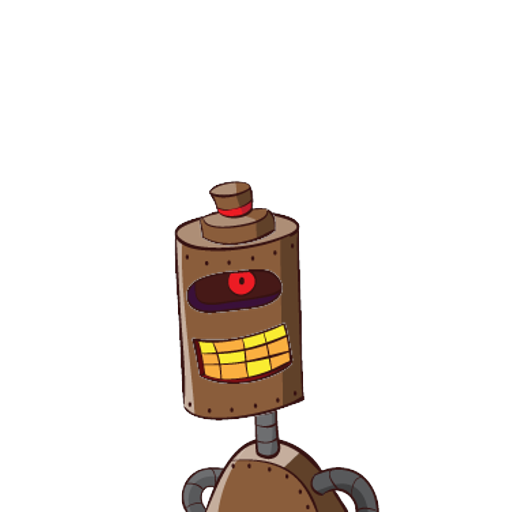

In [6]:
img_gen = ImageGenerator(robot_collection)
phrase = "hamnghi.eth"
my_img = img_gen.generate(phrase, size=(512, 512))
my_img

In [7]:
img_gen._hash("test")

BitArray('0x9ece086e9bac491fac5c1d1046ca11d737b92a2b2ebd93f005d7b710110c0a678288166e7fbe796883a4f2e9b3ca9f484f521d0ce464345cc1aec96779149c14')

## Generative Art for Background

In [8]:
from lxml import etree
from lxml.etree import Element

from delicacy.svglib.utils.utils import eprint, get_canvas, Size
from delicacy.svglib.utils.utils import svg2img, canvas2img

In [9]:
canvas = get_canvas(512, 512)

eprint(canvas)
print(canvas.attrib)

<svg xmlns:xlink="http://www.w3.org/1999/xlink" width="512" height="512" xmlns="http://www.w3.org/2000/svg"/>

{'width': '512', 'height': '512', 'xmlns': 'http://www.w3.org/2000/svg'}


### Style

In [10]:
from delicacy.svglib.elements.peripheral.style import Style, Stroke, Fill

stroke, fill = Stroke(), Fill()
print(stroke)
print(fill)

stroke: black; stroke-opacity: 1; stroke-width: 1;
fill: black; fill-opacity: 1;


### SVGLib

In [11]:
from delicacy.svglib.elements.element import SVGElement, ExtendedElement, svg_define

style_str = 'stroke: black;stroke-opacity: 1;\nfill-opacity: 1;stroke-width: 1;fill: black;'
ExtendedElement.extract_styles(style_str)

{'stroke': 'black',
 'stroke-opacity': '1',
 'fill-opacity': '1',
 'stroke-width': '1',
 'fill': 'black'}

In [12]:
from delicacy.svglib.elements.peripheral.point import (
    Point, 
    rand_bounded_points, 
    rand_fixed_points, 
    rand_points
)
from delicacy.svglib.utils.chain import chainable

In [13]:
from delicacy.svglib.elements.peripheral.transform import Transform
Transform().translate(5).skewX(4)()

'translate(5,0) skewX(4)'

In [14]:
from delicacy.svglib.elements.shapes import Line, Polygon, Circle, Rectangle, Path, XShape, ETriangle

line = Line.make_line(0, 100, 200, 500)

line.add_transform(Transform().translate(4).rotate(45).scale(3))
line.apply_styles(Stroke(), Fill())

eprint(line()); line.styles

<line x1="0" y1="100" x2="200" y2="500" transform="translate(4,0) rotate(45) scale(3,3)" style="stroke: black; stroke-opacity: 1; stroke-width: 1; fill: black; fill-opacity: 1;"/>



{'stroke': 'black',
 'stroke-opacity': '1',
 'stroke-width': '1',
 'fill': 'black',
 'fill-opacity': '1'}

In [15]:
from delicacy.svglib.colors.hsv import HSVColor
from delicacy.svglib.colors.palette import PaletteGenerator
from delicacy.svglib.colors.palette import (
    analogous,
    monochromatic,
    shade,
    tint,
    complementary,
    triad,
    square,
    jewel,
    pastel,
    earth,
    neon,
    palettes
)

In [18]:
from delicacy.svglib.utils.utils import linspace

In [19]:
from delicacy.svglib.elements.element import wraps, defs, group, symbol

In [20]:
from delicacy.svglib.elements.gradient import BaseGradient, LinearGradient, RadialGradient, create_gradient

In [21]:
rg = create_gradient(
    RadialGradient,
    colors=["#e63946", "#e0aaff", "#240046", "#1d3557"]
)

print(defs(rg))

<defs>
  <radialGradient cx="50%" cy="50%" fx="50%" fy="50%" id="radialGradient" r="55%" spreadMethod="pad">
    <stop offset="0%" stop-color="#e63946" stop-opacity="1.0"/>
    <stop offset="33%" stop-color="#e0aaff" stop-opacity="1.0"/>
    <stop offset="67%" stop-color="#240046" stop-opacity="1.0"/>
    <stop offset="100%" stop-color="#1d3557" stop-opacity="1.0"/>
  </radialGradient>
</defs>



In [22]:
def get_reference(element):
    return f"url(#{element.id})"


get_reference(rg)

'url(#radialGradient)'

In [23]:
def karafuru(
    size: Optional[Size] = None,
    n_points: int = 50,
    colors=None,
    n_colors: int = 2,
    gradient_type: str = "linear",
    color_style: str = "neon",
):
    size = Size(512, 512) if size is None else Size(*size)
    canvas = get_canvas(*size)

    if colors is None:
        colors = tuple(
            RGBColor.randcolor(color_style).to_hex() for _ in range(n_colors)
        )

    if gradient_type not in ["linear", "radial"]:
        raise ValueError('gradient_type can only be ["linear", "radial"]')

    gradient = LinearGradient if gradient_type == "linear" else RadialGradient
    gradient = create_gradient(gradient, colors, spreadMethod="reflect")
    defs_gradient = defs(gradient)

    points = rand_fixed_points(n_points, (0, size.width), (0, size.height))
    stroke = Stroke(color=get_reference(gradient), width=2, opacity=1)

    polygon = Polygon(points)
    polygon.set_style(stroke)

    canvas.append(defs_gradient())
    canvas.append(polygon())

    return canvas

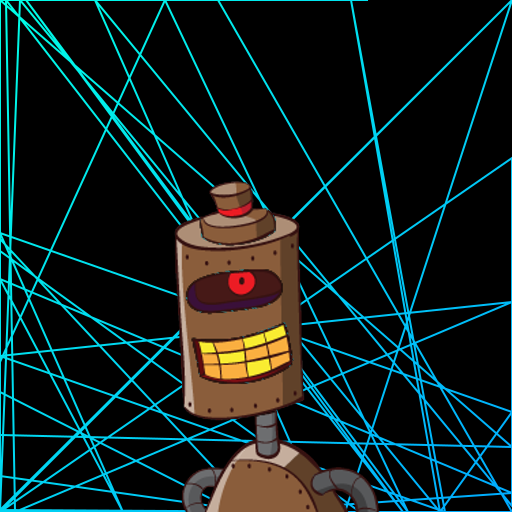

In [24]:
krfr = karafuru(n_colors=2, gradient_type="linear")
bg_img = canvas2img(krfr)
bg_img.paste(my_img, (0, 0), my_img)
bg_img

In [26]:
from random import choice, randint


def randspace(start, stop, n_samples):
    return sorted(set(randint(start, stop) for _ in range(n_samples)))


def teikoku(
    size: Optional[Size] = None,
    x_density: int = 5,
    y_density: int = 40,
    n_colors: int = 5,
    palette_func = None
):
    size = Size(512, 512) if size is None else Size(*size)
    canvas = get_canvas(*size)
    
    if palette_func is None:
        palette_func = random.choice((pastel, neon))
        
    colors = PaletteGenerator(palette_func).generate(num=n_colors)
    
    # colors = tuple(RGBColor.randcolor(color_style) for _ in range(n_colors))

    for yi in linspace(0, size.height, y_density):

        n_lines = randint(1, x_density)
        chunks = randspace(0, size.width, n_lines * 2)

        for i in range(0, len(chunks), 2):
            try:
                startx, endx = chunks[i], chunks[i + 1]
            except IndexError:
                continue
            else:
                stroke = Stroke(color=choice(colors).to_hex(), width=6.5, linecap="round")
                line = Line.make_line(startx, yi, endx, yi)
                line.add_style(stroke)
                canvas.append(line())
    return canvas

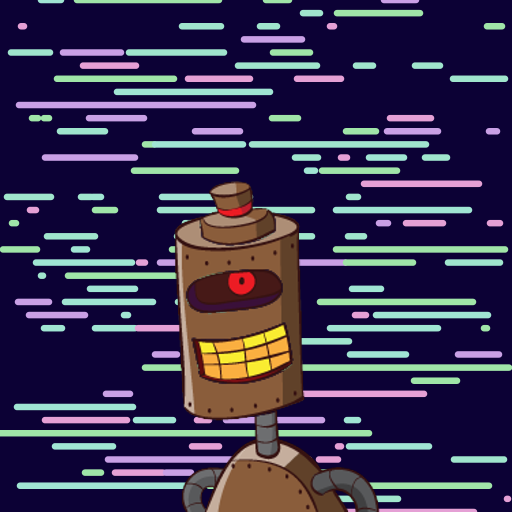

In [27]:
tkk = teikoku()
bg_img = canvas2img(tkk, bg_color="#0c0135")
bg_img.paste(my_img, (0, 0), my_img)
bg_img

## SVG Path

In [28]:
from delicacy.svglib.elements.use import Use
use = Use("something")
str(use)

'<use href="#something" x="0" y="0"/>\n'

In [29]:
from math import sin, radians
from functools import partial


def fade(
    element: ExtendedElement,
    location: Point = Point(0, 0),
    color: Optional[str] = None,
    scale: Optional[float] = None,
    rotate: Optional[float] = None,
    spread: tuple[int, int] = (20, 25),
    fading_scale: float = 0.7,
    k: int = 3,
) -> ExtendedElement:

    if color is None:
        color = RGBColor.randcolor("pastel").to_hex()

    if scale is None:
        scale = random.randint(5, 25) / 100

    if rotate is None:
        rotate = random.randint(0, 360)

    eid = str(id(element))
    # symbol_element = symbol()
    defs_element = defs(group(element, id=eid))

    uses = []
    origin = (0, 0)
    direction = random.choices([-1, 1], k=2)
    width, opacity = 25, 1

    for i in range(k):
        distance = random.choices(range(*spread), k=2)
        new_location = (
            (i * dis * drc) + loc
            for dis, drc, loc in zip(distance, direction, origin)
        )

        use = Use(href=eid, location=new_location)
        use.apply_styles(Stroke(color, opacity, width), Fill(color="none"))

        width *= fading_scale
        opacity *= fading_scale

        uses.append(use)

    _fade = group(defs_element, *uses)
    transform = Transform().translate(*location).scale(scale).rotate(rotate)
    _fade.add_transform(transform)

    return _fade

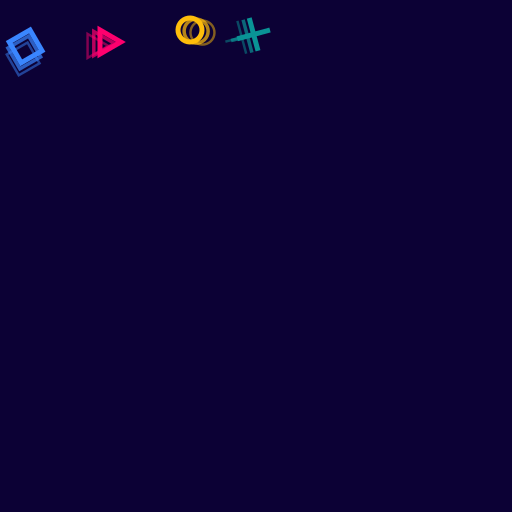

In [30]:
canvas = get_canvas(512, 512)

side = 120

colors = ["#3a86ff", "#ff006e", "#ffbe0b", "#0a9396"]

rec = Rectangle(Point(0, 0), Size(side, side))
frec = fade(
    rec, location=Point(30, 30), color="#3a86ff", scale=0.2, rotate=60
)
canvas.append(frec())


tri = ETriangle(side=side)
ftri = fade(
    tri, location=Point(100, 30), color="#ff006e", scale=0.2, rotate=30
)
canvas.append(ftri())


cir = Circle(side // 2)
fcir = fade(cir, location=Point(190, 30), color="#ffbe0b", scale=0.2)
canvas.append(fcir())


x = XShape(length=side)
fx = fade(x, location=Point(270, 30), color="#0a9396", scale=0.2, rotate=120)
canvas.append(fx())

# eprint(canvas)

bg_img = canvas2img(canvas, bg_color="#0c0135")
bg_img

In [31]:
random.choices(range(50, 460), k=2)

[73, 89]

In [32]:
colors1 = [RGBColor.randcolor("pastel").to_hex() for _ in range(7)]
colors2 = ["#8d43ad", "#cc43c9", "#e644aa", "#f74c78", "#f49683", "#f2d69d"]
colors3 = ["#3a86ff", "#ff006e", "#ffbe0b", "#0a9396"]
colors4 = ["#6e2f74", "#872b73", "#a0256f", "#b62066", "#c9205b", "#d8284c"]
colors5 = ['#f35f3b', '#fec268', '#FFEDD1', '#5af9c3', '#00f596']
colors6 = ['#070707', '#4367c1', '#080c14', '#09183d', '#0b2872']
colors7 = ['#e8907d', '#592c22', '#e03b16', '#fcd9d1', '#7c3424']

analogous


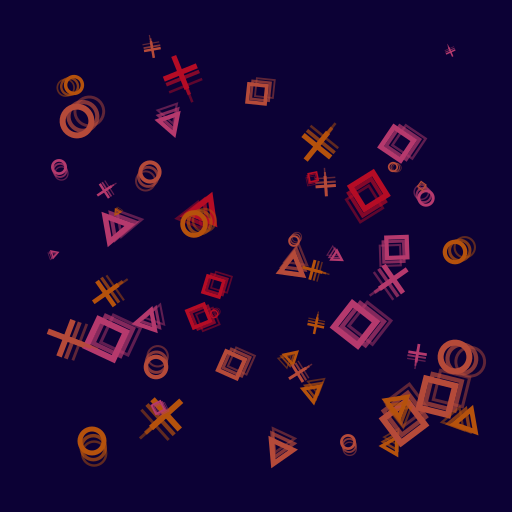

In [46]:
canvas = get_canvas(512, 512)

side = 120
y_axis = 30

# colors = random.choice([colors1, colors2, colors3, colors4])
palette_func = random.choice(tuple(palettes))
print(palette_func.__name__)
colors = [color.to_hex() for color in PaletteGenerator(palette_func).generate(4)]


for y_axis in range(50, 512, 35):
    #     x_axis = range(50, 512, 120)

    rec = Rectangle(Point(0, 0), Size(side, side))
    frec = fade(
        rec,
        location=random.choices(range(50, 460), k=2),
        color=random.choice(colors),
    )
    canvas.append(frec())

    tri = ETriangle(side=side)
    ftri = fade(
        tri,
        location=random.choices(range(50, 460), k=2),
        color=random.choice(colors),
    )
    canvas.append(ftri())

    cir = Circle(side // 2)
    fcir = fade(
        cir,
        location=random.choices(range(50, 460), k=2),
        color=random.choice(colors),
    )
    canvas.append(fcir())

    x = XShape(length=side)
    fx = fade(
        x,
        location=random.choices(range(50, 460), k=2),
        color=random.choice(colors),
    )
    canvas.append(fx())

# eprint(canvas)

bg_img = canvas2img(canvas, bg_color="#0c0135")
bg_img

In [34]:
# eprint(canvas)